### Thiết lập môi trường
Chặn TensorFlow/Flax để tránh xung đột

In [1]:
import os

# Chặn Transformers tự động import TensorFlow/Flax (tránh lỗi protobuf / MessageFactory)
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


print("[OK] Environment flags set (no TF / no Flax).")


[OK] Environment flags set (no TF / no Flax).


### Kiểm tra GPU
Python, PyTorch, CUDA info

In [2]:
import sys, torch
import numpy as np

import transformers, datasets, accelerate

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Accelerate:", accelerate.__version__)


Python: 3.12.12
Torch: 2.8.0+cu126
CUDA: True
GPU: Tesla T4
Transformers: 4.57.1
Datasets: 4.4.1
Accelerate: 1.11.0


### Cài packages
sacrebleu + hf_transfer

In [3]:
import importlib.util, subprocess

def pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# sacrebleu: bắt buộc
if importlib.util.find_spec("sacrebleu") is None:
    print("[INFO] Installing sacrebleu ...")
    pip_install("sacrebleu")
else:
    print("[OK] sacrebleu already installed")

# hf_transfer: optional tăng tốc push/pull
if importlib.util.find_spec("hf_transfer") is None:
    print("[INFO] Installing hf_transfer (optional) ...")
    pip_install("hf_transfer")
else:
    print("[OK] hf_transfer already installed")


[INFO] Installing sacrebleu ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
[OK] hf_transfer already installed


### Import thư viện
Transformers, Datasets, sacrebleu

In [4]:
import re, math, random, hashlib
from pathlib import Path
from typing import List, Dict, Any

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import sacrebleu

print("[OK] Imports done.")


E0000 00:00:1766496889.958279      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766496890.018556      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766496890.534651      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766496890.534688      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766496890.534691      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766496890.534694      55 computation_placer.cc:177] computation placer already registered. Please check linka

[OK] Imports done.


### Tìm dataset
Tự động tìm trên Kaggle

In [5]:
from pathlib import Path

def find_dataset_dir() -> Path:
    base = Path("/kaggle/input")
    for d in base.glob("*"):
        if d.is_dir() and (d / "train.en.txt").exists() and (d / "train.vi.txt").exists():
            return d
    for d in base.glob("*/*"):
        if d.is_dir() and (d / "train.en.txt").exists() and (d / "train.vi.txt").exists():
            return d
    raise FileNotFoundError("Could not find dataset folder containing train.en.txt/train.vi.txt")

DATA_DIR = find_dataset_dir()
print("[OK] Found dataset dir:", DATA_DIR)

TRAIN_EN = DATA_DIR / "train.en.txt"
TRAIN_VI = DATA_DIR / "train.vi.txt"
TEST_EN  = DATA_DIR / "public_test.en.txt"
TEST_VI  = DATA_DIR / "public_test.vi.txt"

for p in [TRAIN_EN, TRAIN_VI, TEST_EN, TEST_VI]:
    print("[CHECK]", p.name, "->", "OK" if p.exists() else "NOT FOUND")


[OK] Found dataset dir: /kaggle/input/databaitoanphu
[CHECK] train.en.txt -> OK
[CHECK] train.vi.txt -> OK
[CHECK] public_test.en.txt -> OK
[CHECK] public_test.vi.txt -> OK


### Load dữ liệu
500k train + 3k test pairs

In [6]:
def read_lines(path: Path, encoding="utf-8"):
    with open(path, "r", encoding=encoding, errors="replace") as f:
        return [line.rstrip("\n") for line in f]

def load_parallel(en_path: Path, vi_path: Path, name="data"):
    en_lines = read_lines(en_path)
    vi_lines = read_lines(vi_path)
    n = min(len(en_lines), len(vi_lines))
    if len(en_lines) != len(vi_lines):
        print(f"[WARN] {name} mismatch -> EN={len(en_lines):,}, VI={len(vi_lines):,}. Using first {n:,} pairs.")
    else:
        print(f"[INFO] {name} lines -> {n:,} pairs.")
    return list(zip(en_lines[:n], vi_lines[:n]))

train_pairs_raw = load_parallel(TRAIN_EN, TRAIN_VI, "train_raw")
test_pairs_raw  = load_parallel(TEST_EN,  TEST_VI,  "test_raw")

print("[SAMPLE train_raw]", train_pairs_raw[0])
print("[SAMPLE test_raw ]", test_pairs_raw[0])


[INFO] train_raw lines -> 500,000 pairs.
[INFO] test_raw lines -> 3,000 pairs.
[SAMPLE train_raw] ('To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên')
[SAMPLE test_raw ] ('Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao', 'Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017')


### Clean dữ liệu
500k → 340k pairs

In [7]:
import re, hashlib

def basic_clean(s: str) -> str:
    s = "" if s is None else s
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

MIN_CHARS = 2
MAX_CHARS = 400

def is_good_pair(src: str, tgt: str) -> bool:
    if not src or not tgt:
        return False
    if len(src) < MIN_CHARS or len(tgt) < MIN_CHARS:
        return False
    if len(src) > MAX_CHARS or len(tgt) > MAX_CHARS:
        return False
    return True

def clean_filter_dedup(pairs, name="data"):
    # clean + filter
    cleaned = []
    for src, tgt in pairs:
        src = basic_clean(src)
        tgt = basic_clean(tgt)
        if is_good_pair(src, tgt):
            cleaned.append((src, tgt))
    print(f"[INFO] {name}: after clean+filter -> {len(cleaned):,} pairs")

    # dedup
    seen = set()
    dedup = []
    for src, tgt in cleaned:
        h = hashlib.md5((src + "\t" + tgt).encode("utf-8")).hexdigest()
        if h not in seen:
            seen.add(h)
            dedup.append((src, tgt))
    print(f"[INFO] {name}: after dedup       -> {len(dedup):,} pairs")
    return dedup

train_pairs = clean_filter_dedup(train_pairs_raw, "train")
test_pairs  = clean_filter_dedup(test_pairs_raw,  "test")

print("[SAMPLE clean train]", train_pairs[0])
print("[SAMPLE clean test ]", test_pairs[0])


[INFO] train: after clean+filter -> 489,008 pairs
[INFO] train: after dedup       -> 340,522 pairs
[INFO] test: after clean+filter -> 2,946 pairs
[INFO] test: after dedup       -> 2,943 pairs
[SAMPLE clean train] ('To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên')
[SAMPLE clean test ] ('Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao', 'Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017')


### Chia train/val/test
30k: Train (29,250) | Val (750)

In [8]:
import random
from datasets import Dataset, DatasetDict

SEED = 42
N_TOTAL = 30000

TRAIN_RATIO = 0.975  # 90/10

# 1) shuffle train_pairs
rng = random.Random(SEED)
rng.shuffle(train_pairs)

# 2) lấy 5000 (nếu không đủ thì lấy hết)
n_take = min(N_TOTAL, len(train_pairs))
subset = train_pairs[:n_take]
print(f"[INFO] Train pairs available: {len(train_pairs):,}")
print(f"[INFO] Taking from train     : {n_take:,} pairs")

# 3) split 90/10
n_train = int(n_take * TRAIN_RATIO)
n_val = n_take - n_train

train_subset = subset[:n_train]
val_subset   = subset[n_train:]

print(f"[INFO] Split -> train={len(train_subset):,} | val={len(val_subset):,}")

# 4) build datasets
train_ds = Dataset.from_dict({
    "src_text": [s for s, _ in train_subset],
    "tgt_text": [t for _, t in train_subset],
})
val_ds = Dataset.from_dict({
    "src_text": [s for s, _ in val_subset],
    "tgt_text": [t for _, t in val_subset],
})

# test giữ nguyên từ public_test
test_ds = Dataset.from_dict({
    "src_text": [s for s, _ in test_pairs],
    "tgt_text": [t for _, t in test_pairs],
})

ds = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
print(ds)

print("[SAMPLE TRAIN]", ds["train"][0])
print("[SAMPLE VAL  ]", ds["validation"][0])
print("[SAMPLE TEST ]", ds["test"][0])


[INFO] Train pairs available: 340,522
[INFO] Taking from train     : 30,000 pairs
[INFO] Split -> train=29,250 | val=750
DatasetDict({
    train: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 29250
    })
    validation: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 750
    })
    test: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 2943
    })
})
[SAMPLE TRAIN] {'src_text': 'Monitor and control ICP using sedatives, endotracheal intubation, hyperventilation, hydration, diuretics, measures to control blood pressure, and sometimes corticosteroids.', 'tgt_text': 'Theo dõi và kiểm soát ICP bằng cách sử dụng thuốc an thần, đặt nội khí quản, tăng thông khí, hydrat hoá, thuốc lợi tiểu, các biện pháp để kiểm soát huyết áp, và đôi khi là corticosteroid.'}
[SAMPLE VAL  ] {'src_text': 'Therefore, we do a study about the expression of hGRα gene in CRSwNP patients.', 'tgt_text': 'Do đó chúng tôi khảo sát sự biều hiện của g

### Load mBART-50
en_XX → vi_VN

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

MODEL_ID = "facebook/mbart-large-50-many-to-many-mmt"
SRC_LANG = "en_XX"
TGT_LANG = "vi_VN"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

# set src/tgt language (QUAN TRỌNG)
tokenizer.src_lang = SRC_LANG
tokenizer.tgt_lang = TGT_LANG   # <-- FIX KeyError: None

forced_bos_token_id = tokenizer.lang_code_to_id[TGT_LANG]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[OK] tokenizer/model loaded")
print("[INFO] tokenizer.src_lang:", tokenizer.src_lang)
print("[INFO] tokenizer.tgt_lang:", tokenizer.tgt_lang)
print("[INFO] forced_bos_token_id:", forced_bos_token_id)


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

[OK] tokenizer/model loaded
[INFO] tokenizer.src_lang: en_XX
[INFO] tokenizer.tgt_lang: vi_VN
[INFO] forced_bos_token_id: 250024


### Translate + Baseline
BLEU = 26.09 (200 samples)

In [12]:
MAX_SRC_LEN = 256
@torch.inference_mode()
def translate_en2vi(
    texts,
    model_,
    tokenizer_,
    num_beams=1,              # ✅ quan trọng nhất
    max_new_tokens=80,
):
    model_.eval()
    tokenizer_.src_lang = SRC_LANG
    tokenizer_.tgt_lang = TGT_LANG

    with torch.no_grad():      # ✅ BẮT BUỘC
        enc = tokenizer_(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_SRC_LEN
        ).to(model_.device)

        generated = model_.generate(
            **enc,
            forced_bos_token_id=tokenizer_.lang_code_to_id[TGT_LANG],
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            early_stopping=True,
        )

    out = tokenizer_.batch_decode(generated, skip_special_tokens=True)

    # ✅ dọn VRAM
    del enc, generated
    torch.cuda.empty_cache()

    return out


def bleu_on_test(max_samples=None):
    srcs = ds["test"]["src_text"]
    refs = ds["test"]["tgt_text"]

    if max_samples is not None:
        srcs = srcs[:max_samples]
        refs = refs[:max_samples]

    hyps = []
    bs = 16 if torch.cuda.is_available() else 4
    for i in range(0, len(srcs), bs):
        hyps.extend(translate_en2vi(srcs[i:i+bs], model, tokenizer))

    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    print(f"[TEST] sacreBLEU ({len(srcs)} samples): {bleu:.2f}")
    return bleu

_ = bleu_on_test(max_samples=200)   # đổi None để chạy full public_test


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[TEST] sacreBLEU (200 samples): 26.09


### Login HF
Xác thực token

In [13]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()

# tên secret của anh là HF_TOKEN (đúng như panel)
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)
print("[OK] Logged in to Hugging Face.")


[OK] Logged in to Hugging Face.


### Load checkpoint
ngothuyet/mbart50-envi

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

HF_REPO = "ngothuyet/mbart50-envi"

tokenizer_fn = AutoTokenizer.from_pretrained(HF_REPO, use_fast=False)
model_fn = AutoModelForSeq2SeqLM.from_pretrained(HF_REPO)

tokenizer_fn.src_lang = "en_XX"
tokenizer_fn.tgt_lang = "vi_VN"

device_fn = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("[OK] Loaded model from HF:", HF_REPO)


tokenizer_config.json:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

[OK] Loaded model from HF: ngothuyet/mbart50-envi


### Tokenize
max_length=256

In [16]:
# đảm bảo ds đã có ở cell split 5000 (train/validation/test)
SRC_LANG = "en_XX"
TGT_LANG = "vi_VN"
MAX_SRC_LEN = 256
MAX_TGT_LEN = 256

def preprocess_batch(batch):
    tokenizer.src_lang = SRC_LANG

    model_inputs = tokenizer(
        batch["src_text"],
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=False,
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["tgt_text"],
            max_length=MAX_TGT_LEN,
            truncation=True,
            padding=False,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = ds["train"].map(preprocess_batch, batched=True, remove_columns=ds["train"].column_names)
val_tok   = ds["validation"].map(preprocess_batch, batched=True, remove_columns=ds["validation"].column_names)
test_tok  = ds["test"].map(preprocess_batch, batched=True, remove_columns=ds["test"].column_names)

print("[OK] Tokenized sizes:",
      "train", len(train_tok),
      "| val", len(val_tok),
      "| test", len(test_tok))


Map:   0%|          | 0/29250 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/2943 [00:00<?, ? examples/s]

[OK] Tokenized sizes: train 29250 | val 750 | test 2943


### Fine-tuning
3 epochs, LR=3e-5

In [17]:
import os, inspect
import torch
import pandas as pd
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)



# Fix stateful tokenizer for mBART-50
tokenizer_fn.src_lang = SRC_LANG
tokenizer_fn.tgt_lang = TGT_LANG

# ====== CONFIG (anh chỉnh ở đây) ======
OUTPUT_DIR  = "mbart50_envi"
NUM_EPOCHS  = 3

TRAIN_BS = 2
EVAL_BS  = 2
GRAD_ACC = 4
LR       = 3e-5

# Hugging Face repo
HF_REPO_ID = "ngothuyet/mbart50-envi"
HF_PRIVATE = True

# ====== DATA COLLATOR ======
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ====== TrainingArguments ======
# Mục tiêu: eval/log theo epoch để có loss, nhưng KHÔNG save checkpoint.
ta_kwargs = dict(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,

    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=LR,
    warmup_ratio=0.03,
    weight_decay=0.01,

    # ✅ log + eval theo epoch để lấy train_loss & val_loss
    predict_with_generate=False,     # chỉ cần loss -> nhanh
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="none",

    # ✅ KHÔNG LƯU CHECKPOINT (tránh lỗi write optimizer.pt)
    save_strategy="no",              # ❌ không checkpoint
    save_only_model=True,            # ❌ không optimizer/scheduler (an toàn)
)

sig = inspect.signature(Seq2SeqTrainingArguments.__init__).parameters

# logging theo epoch
if "logging_strategy" in sig:
    ta_kwargs["logging_strategy"] = "epoch"

# evaluation theo epoch (tên field có thể khác nhau theo version)
if "evaluation_strategy" in sig:
    ta_kwargs["evaluation_strategy"] = "epoch"
elif "eval_strategy" in sig:
    ta_kwargs["eval_strategy"] = "epoch"
else:
    raise ValueError("Transformers version: missing evaluation_strategy/eval_strategy")

# ✅ Push chỉ 1 lần ở cuối (vì không save checkpoint)
# (không dùng hub_strategy="every_save" vì không còn save)
ta_kwargs.update(dict(
    push_to_hub=True,
    hub_model_id=HF_REPO_ID,
    hub_private_repo=HF_PRIVATE,
    hub_strategy="end",              # ✅ chỉ push cuối
))

training_args = Seq2SeqTrainingArguments(**ta_kwargs)

# ====== TRAINER ======
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("[INFO] Start training...")
train_result = trainer.train()
print("\n===== TRAIN DONE =====")
print(train_result)

print("\n===== FINAL EVAL (VAL) =====")
final_metrics = trainer.evaluate()
for k, v in final_metrics.items():
    print(f"{k}: {v}")

# ====== SAVE FINAL LOCAL (model + tokenizer) ======
trainer.save_model(OUTPUT_DIR)          # tạo model.safetensors, config.json,...
tokenizer.save_pretrained(OUTPUT_DIR)   # tokenizer files
print("[OK] Saved final model/tokenizer to:", OUTPUT_DIR)

# ====== EXPORT TSV (train_loss + val_loss) ======
logs = trainer.state.log_history

train_loss_by_epoch = {}
val_loss_by_epoch = {}

for row in logs:
    # train loss rows
    if "epoch" in row and "loss" in row and "eval_loss" not in row:
        train_loss_by_epoch[row["epoch"]] = row["loss"]
    # eval loss rows
    if "epoch" in row and "eval_loss" in row:
        val_loss_by_epoch[row["epoch"]] = row["eval_loss"]

epochs = sorted(set(list(train_loss_by_epoch.keys()) + list(val_loss_by_epoch.keys())))
df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": [train_loss_by_epoch.get(e, None) for e in epochs],
    "val_loss": [val_loss_by_epoch.get(e, None) for e in epochs],
})

tsv_path = os.path.join(OUTPUT_DIR, "train_val_loss.tsv")
df.to_csv(tsv_path, sep="\t", index=False)
print("[OK] Saved TSV:", tsv_path)
display(df)

# ====== PUSH FINAL + TSV ======
# Vì OUTPUT_DIR chứa model + tokenizer + training_args.bin + train_val_loss.tsv
trainer.push_to_hub(commit_message="Final after training (no checkpoints) + train_val_loss.tsv")
print("[OK] Pushed final model + TSV to Hugging Face.")


### Load test
public_test data

In [18]:
from datasets import Dataset

# đọc song song public_test.en/vi -> list[(en, vi)]
test_pairs_raw = load_parallel(TEST_EN, TEST_VI, "test_raw")

# clean/filter/dedup giống pipeline train
test_pairs = clean_filter_dedup(test_pairs_raw, "test")

print(f"[INFO] public_test after clean: {len(test_pairs):,} pairs")
print("[SAMPLE TEST]", test_pairs[0])

# tạo ds_test (giữ nguyên ds train/val của anh nếu đã có)
test_ds = Dataset.from_dict({
    "src_text": [s for s, _ in test_pairs],
    "tgt_text": [t for _, t in test_pairs],
})

# gắn vào DatasetDict nếu đã có ds, còn không thì tạo ds mới
if "ds" in globals():
    ds["test"] = test_ds
else:
    from datasets import DatasetDict
    ds = DatasetDict({"test": test_ds})

print("[OK] ds['test'] size:", len(ds["test"]))


[INFO] test_raw lines -> 3,000 pairs.
[INFO] test: after clean+filter -> 2,946 pairs
[INFO] test: after dedup       -> 2,943 pairs
[INFO] public_test after clean: 2,943 pairs
[SAMPLE TEST] ('Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao', 'Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017')
[OK] ds['test'] size: 2943


### BLEU full test
**BLEU = 43.42**

In [18]:
import os, json, time
import torch
import sacrebleu
from tqdm.auto import tqdm

assert "ds" in globals() and "test" in ds, "Missing ds['test'] - run TEST-LOAD cell first."
assert "translate_en2vi" in globals(), "Missing translate_en2vi() - run inference cell first."
assert "OUTPUT_DIR" in globals(), "Missing OUTPUT_DIR (e.g., 'mbart50_envi')."
assert "trainer" in globals(), "Missing trainer - run training cell first (to push easily)."

def bleu_on_public_test_and_push(batch_size=16):
    srcs = ds["test"]["src_text"]
    refs = ds["test"]["tgt_text"]

    bs = batch_size if torch.cuda.is_available() else max(2, batch_size // 4)

    hyps = []
    t0 = time.time()

    for i in tqdm(range(0, len(srcs), bs), desc="BLEU on public_test", total=(len(srcs) + bs - 1)//bs):
        batch = srcs[i:i+bs]
        hyps.extend(
            translate_en2vi(
                batch,
                num_beams=5,
                length_penalty=1.0,
                no_repeat_ngram_size=3,
                max_new_tokens=128
            )
        )

    bleu = sacrebleu.corpus_bleu(hyps, [refs]).score
    elapsed = time.time() - t0

    metrics = {
        "public_test_sacrebleu": float(bleu),
        "public_test_size": int(len(srcs)),
        "batch_size": int(bs),
        "elapsed_sec": float(elapsed),
    }

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    json_path = os.path.join(OUTPUT_DIR, "public_test_metrics.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    txt_path = os.path.join(OUTPUT_DIR, "public_test_bleu.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(f"public_test_sacrebleu\t{bleu:.4f}\n")

    print(f"\n[PUBLIC_TEST] sacreBLEU ({len(srcs)} samples): {bleu:.2f}")
    print("[OK] Saved:", json_path)
    print("[OK] Saved:", txt_path)

    # push lên repo model
    trainer.push_to_hub(commit_message=f"Add public_test sacreBLEU={bleu:.2f}")
    print("[OK] Pushed public_test BLEU files to Hugging Face.")

    return bleu, metrics

_ = bleu_on_public_test_and_push(batch_size=16)


BLEU on public_test:   0%|          | 0/184 [00:00<?, ?it/s]


[PUBLIC_TEST] sacreBLEU (2943 samples): 43.42
[OK] Saved: mbart50_envi/public_test_metrics.json
[OK] Saved: mbart50_envi/public_test_bleu.txt


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

[OK] Pushed public_test BLEU files to Hugging Face.


### Hiển thị BLEU
Đọc metrics.json

In [19]:
import os, json

json_path = os.path.join(OUTPUT_DIR, "public_test_metrics.json")

with open(json_path, "r", encoding="utf-8") as f:
    metrics = json.load(f)

bleu = metrics["public_test_sacrebleu"]
n = metrics["public_test_size"]

print("="*60)
print(f"✅ sacreBLEU on public_test ({n} sentences): {bleu:.2f}")
print("="*60)


✅ sacreBLEU on public_test (2943 sentences): 43.42


### 5 mẫu dịch
Kiểm tra EN→VI

In [26]:


N_SHOW = 5  # số dòng muốn in

srcs = ds["test"]["src_text"][:N_SHOW]
tgts = ds["test"]["tgt_text"][:N_SHOW]

# dịch
preds = translate_en2vi(
    srcs,
    num_beams=3,
    length_penalty=1.0,
    no_repeat_ngram_size=3,
    max_new_tokens=80,
)

print("=" * 100)
for i, (src, tgt, pred) in enumerate(zip(srcs, tgts, preds), start=1):
    print(f"[{i}] SRC (EN): {src}")
    print(f"    TGT (VI): {tgt}")
    print(f"    PRED(VI): {pred}")
    print("-" * 100)
print("=" * 100)


[1] SRC (EN): Knowledge, practices in public health service utilization among health insurance card’s holders and influencing factors in Vientiane, Lao
    TGT (VI): Thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh Viêng Chăn, CHDCND Lào, năm 2017
    PRED(VI): Kiến thức, thực hành sử dụng dịch vụ y tế công ở người chủ thẻ BHYT và một số yếu tố liên quan tại Vientiane, Lào
----------------------------------------------------------------------------------------------------
[2] SRC (EN): Describe knowledge, practices in public health service utilization among health insurance card's holders and influencing factors in Vientiane, Lao PDR, 2017.
    TGT (VI): Mô tả thực trạng kiến thức, thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố liên quan tại tỉnh Viêng Chăn, Cộng hoà Dân chủ Nhân dân Lào năm 2017.
    PRED(V

### Error helpers
Phát hiện lỗi EN→VI

In [26]:
import re
from collections import Counter
import pandas as pd

# =========================
# Helpers
# =========================
_num_pat = re.compile(r"\d+(?:[.,:/-]\d+)*")
_word_pat = re.compile(r"[A-Za-zÀ-ỹ]+(?:'[A-Za-zÀ-ỹ]+)?|\d+(?:[.,:/-]\d+)*", re.UNICODE)

def _tokenize(s: str):
    return _word_pat.findall((s or "").strip())

def _extract_numbers(s: str):
    return set(_num_pat.findall((s or "")))

def _extract_capitalized_words(s: str):
    # tên riêng đơn giản: token bắt đầu bằng chữ hoa
    toks = _tokenize(s)
    out = set()
    for t in toks:
        if len(t) >= 2 and t[0].isupper() and any(c.isalpha() for c in t):
            out.add(t)
    return out

def _ngram_counts(tokens, n=3):
    if len(tokens) < n:
        return Counter()
    return Counter(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

def _has_repetition(tokens):
    # lặp n-gram: bigram lặp >=3 hoặc trigram lặp >=2
    c2 = _ngram_counts(tokens, n=2)
    c3 = _ngram_counts(tokens, n=3)
    rep2 = (len(c2) > 0) and (max(c2.values()) >= 3)
    rep3 = (len(c3) > 0) and (max(c3.values()) >= 2)
    return rep2 or rep3
_eng_word_pat = re.compile(r"^[a-z]+(?:'[a-z]+)?$", re.I)

def _english_token_ratio(text: str):
    toks = _tokenize((text or "").lower())
    alpha = [t for t in toks if any(c.isalpha() for c in t)]
    if not alpha:
        return 0.0
    eng_like = [t for t in alpha if _eng_word_pat.match(t)]
    return len(eng_like) / len(alpha)

def _vi_diacritic_count(text: str):
    vi_chars = set("ăâđêôơưáàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệ"
                   "íìỉĩịóòỏõọốồổỗộớờởỡợúùủũụứừửữựýỳỷỹỵ")
    t = (text or "").lower()
    return sum(1 for ch in t if ch in vi_chars)


def _jaccard(a, b):
    a, b = set(a), set(b)
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)

# =========================
# Core tagger (rule-based)
# =========================
def tag_mt_errors_en_vi(
    src: str, ref: str, hyp: str,
    omission_ratio=0.75,
    addition_ratio=1.35,
    overlap_literal_thr=0.55,
):
    src = src or ""
    ref = ref or ""
    hyp = hyp or ""

    src_toks = _tokenize(src.lower())
    ref_toks = _tokenize(ref.lower())
    hyp_toks = _tokenize(hyp.lower())

    len_ref = max(1, len(ref_toks))
    len_hyp = len(hyp_toks)
    len_ratio = len_hyp / len_ref

    nums_ref = _extract_numbers(ref)
    nums_hyp = _extract_numbers(hyp)

    overlap_ref_hyp = _jaccard(ref_toks, hyp_toks)
    overlap_src_hyp = _jaccard(src_toks, hyp_toks)

    tags = []

    # ======================
    # Length-based
    # ======================
    if len_ratio < omission_ratio:
        tags.append("Omission_length")
    if len_ratio > addition_ratio:
        tags.append("Addition_length")

    # ======================
    # Number mismatch
    # ======================
    if (nums_ref - nums_hyp):
        tags.append("Number_mismatch_omit")
    if (nums_hyp - nums_ref):
        tags.append("Number_mismatch_add")

    # ======================
    # Repetition
    # ======================
    if _has_repetition(hyp_toks):
        tags.append("Repetition")

    # ======================
    # Literal translation
    # ======================
    if overlap_src_hyp >= overlap_literal_thr:
        tags.append("Literal_translation_suspect")

    # ======================
    # Vietnamese function words (rất quan trọng)
    # ======================
    vi_func_words = {
        "đã", "đang", "sẽ", "của", "và", "là",
        "được", "bị", "cho", "với", "trong",
        "khi", "tại", "theo", "này", "đó"
    }
    if len(ref_toks) >= 8:
        ref_fw = vi_func_words & set(ref_toks)
        hyp_fw = vi_func_words & set(hyp_toks)
        if ref_fw and not hyp_fw:
            tags.append("Vietnamese_function_word_missing")

    # ======================
    # Terminology miss
    # ======================
    long_ref = {t for t in ref_toks if len(t) >= 12}
    if long_ref - set(hyp_toks):
        tags.append("Terminology_miss_suspect")

    # ======================
    # Semantic mismatch proxy
    # ======================
    if ("Omission_length" not in tags) and ("Addition_length" not in tags):
        if overlap_ref_hyp < 0.25 and len_ref >= 6:
            tags.append("Semantic_mismatch_suspect")

    # ======================
    # Punctuation / style
    # ======================
    if ref.strip() and hyp.strip():
        if ref.strip()[-1] in ".?!" and hyp.strip()[-1] not in ".?!":
            tags.append("Punctuation_style")

    info = {
        "len_ratio(hyp/ref)": round(len_ratio, 3),
        "overlap_ref_hyp": round(overlap_ref_hyp, 3),
        "overlap_src_hyp": round(overlap_src_hyp, 3),
        "nums_ref_missing_in_hyp": sorted(nums_ref - nums_hyp),
        "nums_hyp_extra_vs_ref": sorted(nums_hyp - nums_ref),
        "error_tags": ", ".join(tags),
    }

    return tags, info

   



# =========================
# End-to-end: run on your ds["test"]
# =========================
def run_error_analysis_on_ds(
    ds,
    split="test",
    translate_fn=None,         # ví dụ: translate_vi2en
    direction="en-vi",
    batch_size=32,
    max_samples=None,
):
    assert translate_fn is not None, "Anh truyền translate_fn vào (ví dụ translate_vi2en)."

    srcs = ds[split]["src_text"]
    refs = ds[split]["tgt_text"]

    if max_samples is not None:
        srcs = srcs[:max_samples]
        refs = refs[:max_samples]

    # 1) generate hyps theo batch (giống code BLEU của anh)
    hyps = []
    for i in range(0, len(srcs), batch_size):
        hyps.extend(translate_fn(srcs[i:i+batch_size], model_fn, tokenizer_fn))

    # 2) tag lỗi
    rows = []
    counts = Counter()

    for i, (src, ref, hyp) in enumerate(zip(srcs, refs, hyps)):
        tags, info = tag_mt_errors_en_vi(src, ref, hyp)
        for t in tags:
            counts[t] += 1

        rows.append({
            "id": i,
            "src": src,
            "ref": ref,
            "hyp": hyp,
            **info
        })

    df_err = pd.DataFrame(rows)
    summary = pd.DataFrame(
        [{"error_type": k, "count": v, "rate": v/len(df_err)} for k, v in counts.most_common()]
    )

    return df_err, summary


### Error Analysis
Repetition (19%), Number (16%)

In [27]:
df_err, summary = run_error_analysis_on_ds(
    ds=ds,
    split="test",
    translate_fn=translate_en2vi,
    direction="en-vi",
    batch_size=32,
    max_samples=200  # bỏ dòng này nếu muốn chạy full
)

display(summary)
display(df_err[df_err["error_tags"] != ""].head(20))


,error_type,count,rate
0,Repetition,39,0.195
1,Number_mismatch_omit,32,0.160
2,Number_mismatch_add,32,0.160
3,Omission_length,19,0.095
4,Vietnamese_function_word_missing,9,0.045
5,Punctuation_style,7,0.035
6,Addition_length,7,0.035
7,Terminology_miss_suspect,3,0.015
8,Semantic_mismatch_suspect,1,0.005


,id,src,ref,hyp,len_ratio(hyp/ref),overlap_ref_hyp,overlap_src_hyp,nums_ref_missing_in_hyp,nums_hyp_extra_vs_ref,error_tags
0,0,"Knowledge, practices in public health service ...",Thực trạng kiến thức và thực hành của người có...,"Kiến thức, thực hành sử dụng dịch vụ y tế công...",0.578,0.457,0.024,[2017],[],"Omission_length, Number_mismatch_omit"
1,1,"Describe knowledge, practices in public health...","Mô tả thực trạng kiến thức, thực hành của ngườ...","Mô tả kiến thức, thực hành sử dụng dịch vụ y t...",0.608,0.529,0.087,[],[],Omission_length
2,2,Methodology: A cross sectional study was used ...,Phương pháp: Thiết kế nghiên mô tả cắt ngang đ...,Đối tượng và phương pháp nghiên cứu: Nghiên cứ...,0.941,0.378,0.041,[2],[],Number_mismatch_omit
7,7,Conclusions: Knowledge and practices in public...,Kết luận: Kiến thức và thực hành của người có ...,Kết luận: Kiến thức và thực hành sử dụng dịch ...,0.742,0.767,0.000,[],[],Omission_length
8,8,It's necessary to provide health insurance com...,Cần tập trung vào truyền thông cho những nhóm ...,Cần thiết cung cấp dịch vụ bảo hiểm y tế truyề...,1.107,0.417,0.000,[],[],Repetition
10,10,In order to contribute to the detection of ban...,Để góp phần vào công tác kiểm tra phát hiện cá...,Để góp phần phát hiện các chất cấm trong các d...,0.851,0.561,0.026,[],[],Repetition
11,11,"After precipating, diclofenac sodium was elute...",Sau khi xử lý mẫu diclofenac natri được tiến h...,"Sau khi ngấm, diclofenac natri được tách bằng ...",0.817,0.515,0.203,"[0, 0:3, 275, 7]",[70:30],"Number_mismatch_omit, Number_mismatch_add, Pun..."
18,18,mice were fed with distilled water (group 2) m...,"Sau đó với lô 2 chuột được uống nước cất, lô 3...",chuột được cho ăn dịch chiết dịch bằng nước cấ...,0.667,0.613,0.282,[],[24],"Omission_length, Number_mismatch_add, Repetition"
20,20,Mice in each group was assessed for weight wee...,Trọng lượng chuột ở mỗi lô được đánh giá hàng ...,Các con chuột được đánh giá cân nặng hàng tuần...,1.000,0.446,0.141,[],[],Punctuation_style
21,21,The results showed that the mixture extract of...,Kết quả cho thấy hỗn hợp dịch chiết lá Trà hoa...,Kết quả cho thấy cao chiết C. chrysantha và G....,0.613,0.397,0.286,"[3,4,5]","[3, 4, 5]","Omission_length, Number_mismatch_omit, Number_..."


### Biểu đồ lỗi
Bar chart

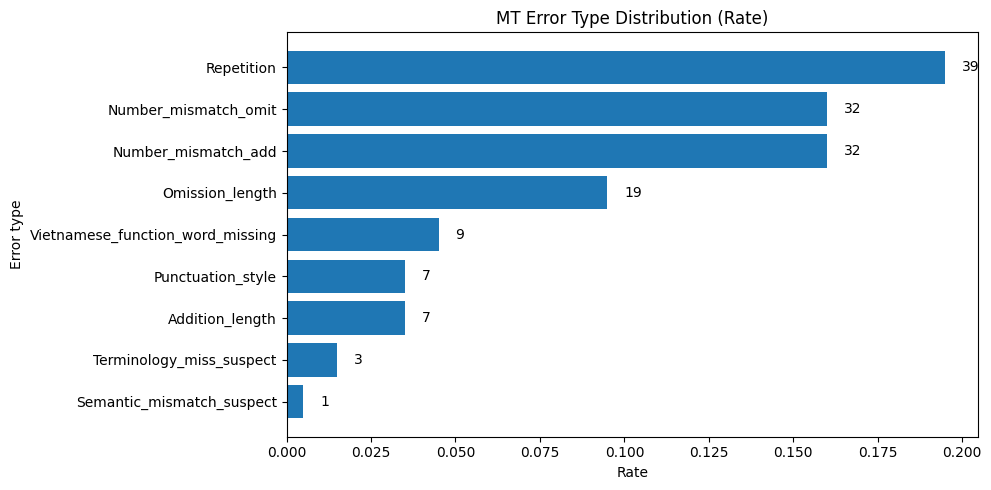

In [28]:
import matplotlib.pyplot as plt

# summary: DataFrame có các cột ["error_type","count","rate"]
# nếu summary của anh đang tên khác thì đổi lại biến

dfp = summary.sort_values("rate", ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(dfp["error_type"], dfp["rate"])
plt.xlabel("Rate")
plt.ylabel("Error type")
plt.title("MT Error Type Distribution (Rate)")

# ghi count lên mỗi cột
for i, (rate, cnt) in enumerate(zip(dfp["rate"], dfp["count"])):
    plt.text(rate + 0.005, i, f"{cnt}", va="center")  # +0.005 để chữ không đè lên cột

plt.tight_layout()
plt.show()


### Init Gemini
API client

In [17]:
# CELL 1: Init Gemini client (Kaggle)

from kaggle_secrets import UserSecretsClient
from google import genai
import os

# đọc secret
API_KEY = UserSecretsClient().get_secret("GeminiAPI")

# (tuỳ chọn) set env
os.environ["GeminiAPI"] = API_KEY

# init client
client = genai.Client(api_key=API_KEY)

print("✅ Gemini client initialized")


✅ Gemini client initialized


### Gemini function
Chấm điểm EN→VI

In [18]:
# CELL 2: Gemini judge functions

import json
import time
from typing import List, Tuple, Optional
from tqdm.auto import tqdm

JUDGE_SYSTEM = """You are a strict evaluator.
Score the candidate translation against the reference.
Return ONLY valid JSON:
{
  "score": integer from 0 to 100,
  "rationale": short Vietnamese explanation (1-2 sentences)
}
"""

def build_prompt(src_en: str, ref_vi: str, hyp_vi: str) -> str:
    return f"""
SOURCE (EN):
{src_en}

REFERENCE (VI):
{ref_vi}

CANDIDATE (VI):
{hyp_vi}
"""

def gemini_judge_one(
    src_en: str,
    ref_vi: str,
    hyp_vi: str,
    model: str = "gemini-2.5-flash",
    max_retries: int = 8,
    base_sleep: float = 2.0,   # sleep nền
) -> Tuple[Optional[int], str]:
    prompt = build_prompt(src_en, ref_vi, hyp_vi)
    last_err = ""

    for attempt in range(max_retries):
        try:
            resp = client.models.generate_content(
                model=model,
                contents=prompt,
                config={
                    "system_instruction": JUDGE_SYSTEM,
                    "temperature": 0.0,
                    "response_mime_type": "application/json",
                },
            )

            data = json.loads((resp.text or "").strip())
            score = int(data.get("score"))
            score = max(0, min(100, score))
            rationale = str(data.get("rationale", "")).strip()
            return score, rationale

        except Exception as e:
            last_err = str(e)

            # ✅ Nếu 429 RESOURCE_EXHAUSTED -> backoff mạnh dần
            if "429" in last_err or "RESOURCE_EXHAUSTED" in last_err:
                sleep = base_sleep * (2 ** attempt) + random.uniform(0, 1.0)
                print(f"[429] Rate limit/quota. Sleep {sleep:.1f}s (attempt {attempt+1}/{max_retries})")
                time.sleep(sleep)
                continue

            # lỗi khác: thử nhẹ 1 lần rồi trả
            time.sleep(1.0)

    return None, f"ERROR: {last_err}"

### Score 10 câu
Gemini scoring

In [29]:
# CELL 3: Score first 200 public-test sentences

import pandas as pd
import matplotlib.pyplot as plt

# load test files (đã có trong notebook anh)
en_src = read_lines(TEST_EN)
vi_ref = read_lines(TEST_VI)

N = 10   # đổi 1 để test nhanh
en_part = en_src[:N]
ref_part = vi_ref[:N]

# dịch (dùng hàm có sẵn của anh)
pred_part = translate_en2vi(en_part)

rows = []
for i in tqdm(range(N), desc="Gemini scoring"):
    score, rationale = gemini_judge_one(
        src_en=en_part[i],
        ref_vi=ref_part[i],
        hyp_vi=pred_part[i],
    )
    rows.append({
        "idx": i,
        "en_src": en_part[i],
        "in_ref": ref_part[i],
        "in_pred": pred_part[i],
        "gemini_score": score,
        "rationale": rationale,
    })
    time.sleep(1)

df_gemini = pd.DataFrame(rows)




### Luật Y Khoa
Định nghĩa rules

In [25]:
base_scores, ft_scores, reasons = [], [], []

for i in range(len(en_part)):
    b_score, b_notes = score_one(base_hyp[i], vi_ref[i])
    f_score, f_notes = score_one(ft_hyp[i], vi_ref[i])

    base_scores.append(b_score)
    ft_scores.append(f_score)

    b_txt = "; ".join(b_notes) if b_notes else "đúng y khoa"
    f_txt = "; ".join(f_notes) if f_notes else "đúng y khoa"

    reasons.append(f"Base: {b_txt}. FT: {f_txt}.")

print("✅ Base mean:", sum(base_scores)/len(base_scores))
print("✅ FT mean:", sum(ft_scores)/len(ft_scores))


✅ Base mean: 67.12066666666666
✅ FT mean: 72.945


### So sánh scores
Base: 67.1, FT: 72.9

In [ ]:
import pandas as pd

# ✅ chọn câu dịch để lưu ở cột "câu đích được dịch"
# mặc định em lưu bản Fine-tuned (ft_hyp). Nếu muốn lưu Base thì đổi thành base_hyp
hyp_to_save = ft_hyp


df_out = pd.DataFrame({
    "stt": list(range(1, len(vi_part) + 1)),
    "câu nguồn": vi_part,
    "câu đích chuẩn từ tập test": en_ref,
    "câu đích được dịch": hyp_to_save,
    "base_score": base_scores,
    "ft_score": ft_scores,
    "reason": reasons,   # đã có "Base: ... FT: ..." và lỗi cụ thể
})

out_path = "gemini_score_VI_EN.csv"
df_out.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", out_path)

df_out.head(5)
